---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Valeria Viales Vega**
* Carné: **B67709**
* Grupo: **2**

---
# `P4` - *Modulación digital IQ*

> La modulación digital es una de las aplicaciones directas del análisis de procesos estocásticos, presente en los sistemas digitales de comunicación. Este proyecto presenta una introdución a tópicos fundamentales de la ingeniería de comunicaciones para simular un sistema de transmisión de imágenes de baja resolución.

---
* Elaboración de nota teórica y demostración: **Jeaustin Sirias Chacón**, como parte de IE0499 - Proyecto Eléctrico: *Estudio y simulación de aplicaciones de la teoría de probabilidad en la ingeniería eléctrica*.
* Revisión: **Fabián Abarca Calderón**

#### 3.1.1 - Extracción de los pixeles de una imagen (fuente de información)

In [4]:
from PIL import Image
import numpy as np

def fuente_info(imagen):
    '''Una función que simula una fuente de
    información al importar una imagen y 
    retornar un vector de NumPy con las 
    dimensiones de la imagen, incluidos los
    canales RGB: alto x largo x 3 canales

    :param imagen: Una imagen en formato JPG
    :return: un vector de pixeles
    '''
    img = Image.open(imagen)
    
    return np.array(img)

#### 3.1.2. - Codificación de pixeles a una base binaria (bits)

In [5]:
import numpy as np

def rgb_a_bit(imagen):
    '''Convierte los pixeles de base 
    decimal (de 0 a 255) a binaria 
    (de 00000000 a 11111111).

    :param imagen: array de una imagen 
    :return: Un vector de (1 x k) bits 'int'
    '''
    # Obtener las dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

    # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

In [80]:
import numpy as np

def modulador(bits, fc, mpp):
    '''Un método que simula el esquema de 
    modulación digital BPSK.

    :param bits: Vector unidimensional de bits
    :param fc: Frecuencia de la portadora en Hz
    :param mpp: Cantidad de muestras por periodo de onda portadora
    :return: Un vector con la señal modulada
    :return: Un valor con la potencia promedio [W]
    :return: La onda portadora c(t)
    :return: La onda cuadrada moduladora (información)
    '''
    # 1. Parámetros de la 'señal' de información (bits)
    N = len(bits) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora c(t)
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    portadora = np.sin(2*np.pi*fc*t_periodo)

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_Tx = np.zeros(t_simulacion.shape)
    moduladora = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i, bit in enumerate(bits):
        if bit == 1:
            senal_Tx[i*mpp : (i+1)*mpp] = portadora
            moduladora[i*mpp : (i+1)*mpp] = 1
        else:
            senal_Tx[i*mpp : (i+1)*mpp] = portadora * -1
            moduladora[i*mpp : (i+1)*mpp] = 0
    
    # 5. Calcular la potencia promedio de la señal modulada
    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    
    return senal_Tx, Pm, portadora, moduladora  

#### 3.1.4. - Construcción de un canal con ruido AWGN

In [7]:
import numpy as np

def canal_ruidoso(senal_Tx, Pm, SNR):
    '''Un bloque que simula un medio de trans-
    misión no ideal (ruidoso) empleando ruido
    AWGN. Pide por parámetro un vector con la
    señal provieniente de un modulador y un
    valor en decibelios para la relación señal
    a ruido.

    :param senal_Tx: El vector del modulador
    :param Pm: Potencia de la señal modulada
    :param SNR: Relación señal-a-ruido en dB
    :return: La señal modulada al dejar el canal
    '''
    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

#### 3.1.5. - Esquema de demodulación

In [8]:
import numpy as np

def demodulador(senal_Rx, portadora, mpp):
    '''Un método que simula un bloque demodulador
    de señales, bajo un esquema BPSK. El criterio
    de demodulación se basa en decodificación por 
    detección de energía.

    :param senal_Rx: La señal recibida del canal
    :param portadora: La onda portadora c(t)
    :param mpp: Número de muestras por periodo
    :return: Los bits de la señal demodulada
    '''
    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N = int(M / mpp)

    # Vector para bits obtenidos por la demodulación
    bits_Rx = np.zeros(N)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(M)

    # Energía de un período de la portadora
    Es = np.sum(portadora**2)

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        producto = senal_Rx[i*mpp : (i+1)*mpp] * portadora
        senal_demodulada[i*mpp : (i+1)*mpp] = producto
        Ep = np.sum(producto) 

        # Criterio de decisión por detección de energía
        if Ep > Es*0.8:
            bits_Rx[i] = 1
        else:
            bits_Rx[i] = 0

    return bits_Rx.astype(int), senal_demodulada

#### 3.1.6. - Reconstrucción de la imagen

In [9]:
import numpy as np

def bits_a_rgb(bits_Rx, dimensiones):
    '''Un blque que decodifica el los bits
    recuperados en el proceso de demodulación

    :param: Un vector de bits 1 x k 
    :param dimensiones: Tupla con dimensiones de la img.
    :return: Un array con los pixeles reconstruidos
    '''
    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)

### 3.2. - Simulación del sistema de comunicaciones con modulación BPSK

**Nota**: esta simulación tarda un poco.

Duración de la simulación:  13.828176975250244
12497 errores, para un BER de 0.0295.


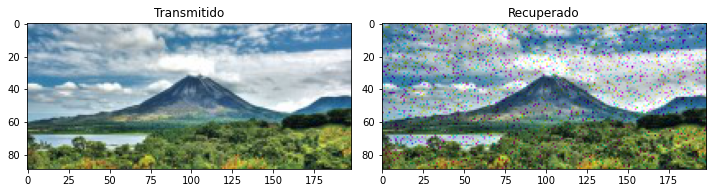

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 5    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema BPSK
senal_Tx, Pm, portadora, moduladora = modulador(bits_Tx, fc, mpp)

# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora, mpp)

# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

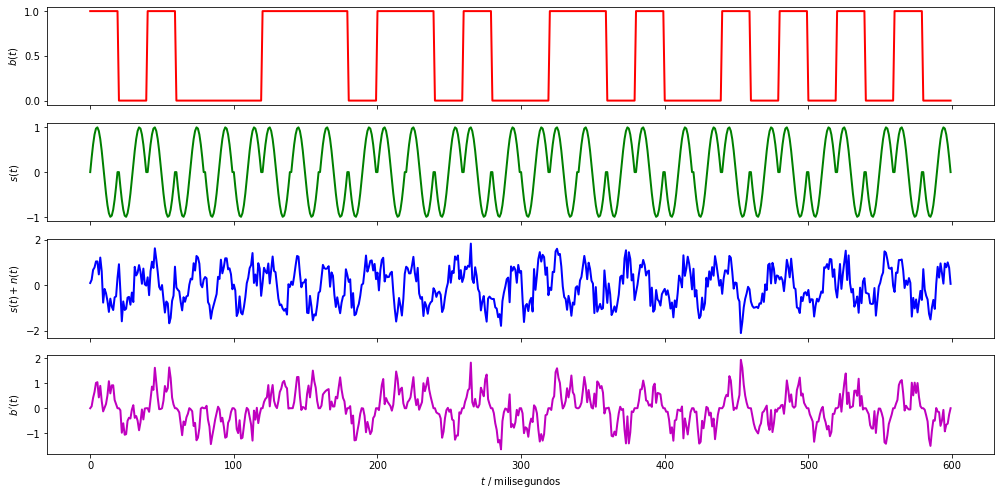

In [11]:
import matplotlib.pyplot as plt

# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(14, 7))

# La onda cuadrada moduladora (bits de entrada)
ax1.plot(moduladora[0:600], color='r', lw=2) 
ax1.set_ylabel('$b(t)$')

# La señal modulada por BPSK
ax2.plot(senal_Tx[0:600], color='g', lw=2) 
ax2.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax3.plot(senal_Rx[0:600], color='b', lw=2) 
ax3.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax4.plot(senal_demodulada[0:600], color='m', lw=2) 
ax4.set_ylabel('$b^{\prime}(t)$')
ax4.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()

In [16]:
#4.1. Modulación QSPK
import numpy as np

def modulador(bits, fc, mpp):
    '''
    :param bits: Vector unidimensional de bits
    :param fc: Frecuencia de la portadora en Hz
    :param mpp: Cantidad de muestras por periodo de onda portadora
    :return: Un vector con la señal modulada
    :return: Un valor con la potencia promedio [W]
    :return: La onda portadora c(t)
    :return: La onda cuadrada moduladora (información)
    '''
    # 1. Parámetros de la 'señal' de información (bits)
    N = len(bits) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora c(t)
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    portadora = np.sin(2*np.pi*fc*t_periodo)
    portadora_ = np.cos(2*np.pi*fc*t_periodo)

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_Tx = np.zeros(t_simulacion.shape)
    senal_Tx_ = np.zeros(t_simulacion.shape)
    moduladora = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i in range(0, N, 2):
        tam = bits[i]
        
        if tam == 1:
            senal_Tx[ i*mpp : (i+1)*mpp] = portadora
        else:
            senal_Tx[i*mpp : (i+1)*mpp] = (portadora * -1)
    
    for i in range(1, N, 2):
        tam_ = bits[i]
        if tam_ == 1:
            senal_Tx_[ i*mpp : (i+1)*mpp ] = portadora_
            
        else: 
            senal_Tx_[i*mpp : (i+1)*mpp] = (portadora_ * -1)
    
    Rsenal_Tx = senal_Tx + senal_Tx_
    Rportadora = portadora + portadora_
            
    
    # 5. Calcular la potencia promedio de la señal modulada
    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    
    return senal_Tx, Pm, portadora

Duración de la simulación:  8.14798903465271
110582 errores, para un BER de 0.26.


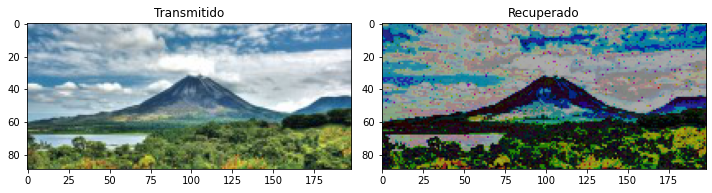

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 5    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema BPSK
senal_Tx, Pm, portadora = modulador(bits_Tx, fc, mpp)

# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora, mpp)

# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.2f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

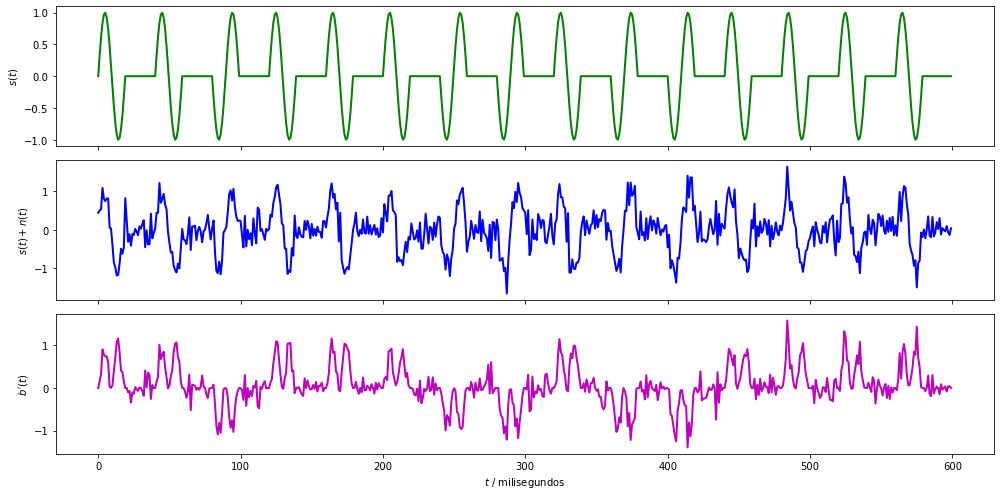

In [38]:
import matplotlib.pyplot as plt

# Visualizar el cambio entre las señales
fig, (ax2, ax3, ax4) = plt.subplots(nrows=, sharex=True, figsize=(14, 7))

# La señal modulada por BPSK
ax2.plot(senal_Tx[0:600], color='g', lw=2) 
ax2.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax3.plot(senal_Rx[0:600], color='b', lw=2) 
ax3.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax4.plot(senal_demodulada[0:600], color='m', lw=2) 
ax4.set_ylabel('$b^{\prime}(t)$')
ax4.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()

---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---

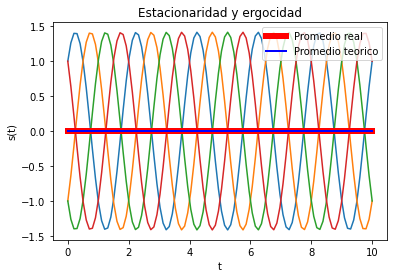

In [115]:
# 4.2. Estacionaridad y ergodicidad 

import numpy as np
import matplotlib.pyplot as plt
import time

#Se genera arreglo 

array = np.linspace(0, 10, 100)

l = [1, -1]

s_a = np.empty((4, len(array)))

# Se calculan las funciones

for i in l:
    s1 = i*(np.sin(2*np.pi*fc*array) + np.cos(2*np.pi*fc*array))
    s2 = i*(np.sin(2*np.pi*fc*array) - np.cos(2*np.pi*fc*array))
    
    s_a[i,:] = s1
    s_a[i+1,:] = s2
    plt.plot(array, s1)
    plt.plot(array, s2)

#Cálculo de la media y el valor esperado de la señal

for i in range(len(array)):
    np.mean(s_a[:,i])

plt.plot(array, A, lw = 6, color='r', label = "Promedio real")

E = np.mean(Rsenal_Tx)*array
plt.plot(array, E, '-', lw = 2, color = 'b', label = "Promedio teorico")

plt.title('Estacionaridad y ergocidad')
plt.ylabel("s(t)")
plt.xlabel("t")
plt.legend()

<ipython-input-116-8b6333acfc90>:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  sig = fft(Rsenal_Tx)


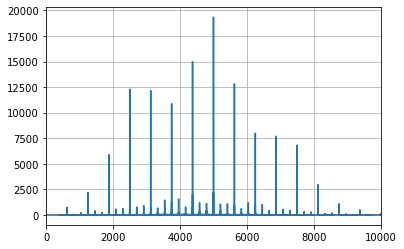

In [116]:
#4.3. Densidad espectral de potencia
from scipy import fft

# Se obtiene la transformada de fourier
sig = fft(Rsenal_Tx)

n_m = len(Rsenal_Tx)

# Tiempo que tarda la simulación en llevarse a cabo
t = (n_m//mpp)*(1/fc)

f = np.linspace(0.0, 1.0/(2.0*((1/fc)/mpp)), n_m//2)


plt.plot(f,3/n_m*np.power(np.abs(sig[0:n_m//2]),2))
plt.xlim(0,10000)
plt.grid()
plt.show()